This notebook will be used to create biochem open boundary conditions, starting with SJDF, for full domain. 

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import os

# database stuff:
import sqlalchemy
from sqlalchemy import create_engine, Column, String, Integer, Numeric, MetaData, Table, type_coerce, ForeignKey, case
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
from sqlalchemy.ext.automap import automap_base
import sqlalchemy.types as types
import numbers
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import glob
import re
import gsw

%matplotlib inline

N2chl=1.600

# Load 3D T+S


In [2]:
# define constant values, not yet based on data:
val_bSi=7.74709546875e-06
val_DIA=1e-8
val_CRY=1e-8
val_MYRI=1e-8
val_MICZ=1e-8
val_Oxy = 160.0

In [3]:
TS = nc.Dataset('/data/dlatorne/MEOPAR/nowcast-green/open_boundaries/west/SalishSea_west_TEOS10.nc')

In [4]:
s=''
for key in TS.variables.keys():
    s=s+key+', '
print(s)

deptht, nav_lat, nav_lon, nbidta, nbjdta, nbrdta, time_counter, vosaline, votemper, 


In [5]:
print(TS.dimensions)

OrderedDict([('deptht', <class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 40
), ('yb', <class 'netCDF4._netCDF4.Dimension'>: name = 'yb', size = 1
), ('xbT', <class 'netCDF4._netCDF4.Dimension'>: name = 'xbT', size = 870
), ('time_counter', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 52
)])


In [6]:
for key in TS.variables.keys():
    print(key, np.shape(TS.variables[key]))

deptht (40,)
nav_lat (1, 870)
nav_lon (1, 870)
nbidta (1, 870)
nbjdta (1, 870)
nbrdta (1, 870)
time_counter (52,)
vosaline (52, 40, 1, 870)
votemper (52, 40, 1, 870)


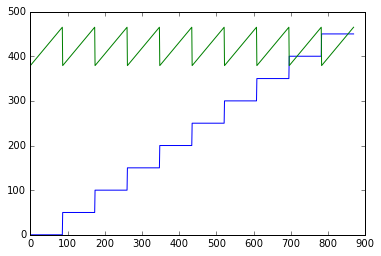

In [7]:
plt.plot(TS.variables['nbidta'][0,:]*50)
plt.plot(TS.variables['nbjdta'][0,:])

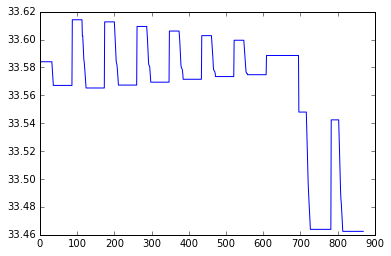

In [8]:
plt.plot(TS.variables['vosaline'][5,30,0,:])

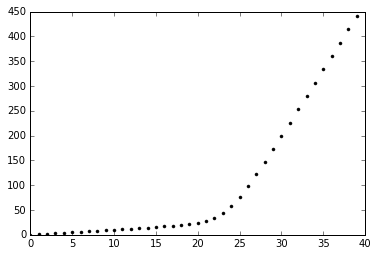

In [9]:
plt.plot(TS.variables['deptht'],'k.')

#Save to netcdf

In [10]:
new = nc.Dataset('/ocean/eolson/MEOPAR/NEMO-3.6-inputs/boundary_conditions/bioOBC_full.nc', 'w', zlib=True)
#Copy dimensions
for dname, the_dim in TS.dimensions.items():
    #print (dname, len(the_dim) if not the_dim.isunlimited() else None)
    new.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)

In [11]:
# create dimension variables:
# deptht
deptht=new.createVariable('deptht','float32',('deptht',))
deptht.long_name = 'Vertical T Levels'
deptht.units = 'm'
deptht.positive = 'down'
deptht.valid_range = np.array((4., 428.))
deptht[:]=TS.variables['deptht']

#nav_lat
nav_lat = new.createVariable('nav_lat','float32',('yb','xbT'))
nav_lat.long_name = TS.variables['nav_lat'].long_name
nav_lat.units = TS.variables['nav_lat'].units
nav_lat[:] = TS.variables['nav_lat']

#nav_lon
nav_lon = new.createVariable('nav_lon','float32',('yb','xbT'))
nav_lon.long_name = TS.variables['nav_lon'].long_name
nav_lon.units = TS.variables['nav_lon'].units
nav_lon[:]=TS.variables['nav_lon']

# nbidta
nbidta=new.createVariable('nbidta','int32',('yb','xbT'))
nbidta.long_name = TS.variables['nbidta'].long_name
nbidta.units = TS.variables['nbidta'].units
nbidta[:]=TS.variables['nbidta']

# nbjdta
nbjdta=new.createVariable('nbjdta','int32',('yb','xbT'))
nbjdta.long_name = TS.variables['nbjdta'].long_name
nbjdta.units = TS.variables['nbjdta'].units
nbjdta[:]=TS.variables['nbjdta']

# nbrdta
nbrdta=new.createVariable('nbrdta','int32',('yb','xbT'))
nbrdta.long_name = TS.variables['nbrdta'].long_name
nbrdta.units = TS.variables['nbrdta'].units
nbrdta[:]=TS.variables['nbrdta']

# time_counter
time_counter = new.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.long_name = 'Time axis'
time_counter.axis = 'T'
time_counter.units = 'weeks since beginning of year'
time_counter[:]=TS.variables['time_counter']

In [12]:
print(TS.variables['vosaline'])

<class 'netCDF4._netCDF4.Variable'>
float32 vosaline(time_counter, deptht, yb, xbT)
    coordinates: nav_lon nav_lat deptht time_counter
    grid: SalishSea
    units: g/kg
    long_name: Reference Salinity
unlimited dimensions: time_counter
current shape = (52, 40, 1, 870)
filling on, default _FillValue of 9.969209968386869e+36 used



In [13]:
# variables
#NO3, Si, NH4, PHY, PHY2, MYRI, MICZ, POC, DOC, bSi

# NO3
voNO3 = new.createVariable('NO3', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voNO3.grid = TS.variables['votemper'].grid
voNO3.units = 'muM'
voNO3.long_name = 'Nitrate' 
# don't yet set values

#Si
voSi = new.createVariable('Si', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voSi.grid = TS.variables['votemper'].grid
voSi.units = 'muM'
voSi.long_name = 'Silica' 
# don't yet set values

#NH4
voNH4 = new.createVariable('NH4', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voNH4.grid = TS.variables['votemper'].grid
voNH4.units = 'muM'
voNH4.long_name = 'Ammonia' 
# don't yet set values

#DIA
voDIA = new.createVariable('DIA', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voDIA.units = 'muM N'
voDIA.long_name = 'Diatoms'
voDIA.grid = TS.variables['votemper'].grid
voDIA[:]=val_DIA

#CRY
voCRY = new.createVariable('CRY', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voCRY.units = 'muM N'
voCRY.long_name = 'Cryptophytes'
voCRY.grid = TS.variables['votemper'].grid
voCRY[:]=val_CRY

#MYRI
voMYRI = new.createVariable('MYRI', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voMYRI.units = 'muM N'
voMYRI.long_name = 'M. rubra' 
voMYRI.grid = TS.variables['votemper'].grid
voMYRI[:]=val_MYRI

#MICZ
voMICZ = new.createVariable('MICZ', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voMICZ.units = 'muM N'
voMICZ.long_name = 'Microzooplankton' 
voMICZ.grid = TS.variables['votemper'].grid
voMICZ[:]=val_MICZ

#PON
voPON = new.createVariable('PON', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voPON.units = 'muM N'
voPON.long_name = 'Particulate Organic Nitrogen'
voPON.grid = TS.variables['votemper'].grid
#voPON[:] = val_PON

#DON
voDON = new.createVariable('DON', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voDON.units = 'muM N'
voDON.long_name = 'Dissolved Organic Nitrogen'
voDON.grid = TS.variables['votemper'].grid
#voDON[:]=DON_val

#bSi
vobSi = new.createVariable('bSi', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
vobSi.units = 'muM N'
vobSi.long_name = 'Biogenic Silica'
vobSi.grid = TS.variables['votemper'].grid
vobSi[:]=val_bSi

#O2
voO2 = new.createVariable('O2', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
#voO2.units = ''
voO2.long_name = 'oxygen'
voO2.grid = TS.variables['votemper'].grid
voO2[:]=val_Oxy


# load database for data-based conditions

In [14]:
# definitions
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'DFOOPDB/'
dbname='DFO_OcProfDB'

# engine and reflection
Base = automap_base()
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = False)
Base.prepare(engine, reflect=True)
Station=Base.classes.StationTBL
Obs=Base.classes.ObsTBL
JDFLocs=Base.classes.JDFLocsTBL
Calcs=Base.classes.CalcsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

# column definitions
SA=case([(Calcs.Salinity_Bottle_SA!=None, Calcs.Salinity_Bottle_SA)], else_=
         case([(Calcs.Salinity_T0_C0_SA!=None, Calcs.Salinity_T0_C0_SA)], else_=
         case([(Calcs.Salinity_T1_C1_SA!=None, Calcs.Salinity_T1_C1_SA)], else_=
         case([(Calcs.Salinity_SA!=None, Calcs.Salinity_SA)], else_=
         case([(Calcs.Salinity__Unknown_SA!=None, Calcs.Salinity__Unknown_SA)], else_=Calcs.Salinity__Pre1978_SA)
        ))))
NO=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Nitrate_plus_Nitrite)], else_=Obs.Nitrate)
NOUnits=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Nitrate_plus_Nitrite_units)], else_=Obs.Nitrate_units)
NOFlag=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Flag_Nitrate_plus_Nitrite)], else_=Obs.Flag_Nitrate)
# Obs.Quality_Flag_Nitr does not match any nitrate obs
# ISUS not included in this NO
Tem=case([(Obs.Temperature!=None, Obs.Temperature)], else_=
         case([(Obs.Temperature_Primary!=None, Obs.Temperature_Primary)], else_=
         case([(Obs.Temperature_Secondary!=None, Obs.Temperature_Secondary)], else_=Obs.Temperature_Reversing)))
TemUnits=case([(Obs.Temperature!=None, Obs.Temperature_units)], else_=
         case([(Obs.Temperature_Primary!=None, Obs.Temperature_Primary_units)], else_=
         case([(Obs.Temperature_Secondary!=None, Obs.Temperature_Secondary_units)], 
              else_=Obs.Temperature_Reversing_units)))
TemFlag=Obs.Quality_Flag_Temp
Ox=case([(Calcs.Oxygen_umolL!=None, Calcs.Oxygen_umolL)], else_=Calcs.Oxygen_Dissolved_umolL)
OxFlag=case([(Calcs.Oxygen_umolL!=None, Obs.Quality_Flag_Oxyg)], else_=Obs.Flag_Oxygen_Dissolved)
Press=case([(Obs.Pressure!=None, Obs.Pressure)], else_=Obs.Pressure_Reversing)

Ammonium:

In [15]:
q=session.query(JDFLocs.ObsID, Station.StartYear,Station.StartMonth,Press,
                Obs.Ammonium,Obs.Ammonium_units,Tem,SA).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Station,Station.ID==Obs.StationTBLID).\
        join(Calcs,Calcs.ObsID==Obs.ID).filter(Obs.Ammonium!=None).\
        all()
qYr=[]
qMn=[]
qP=[]
qNH=[]
qTC=[]
qSA=[]
remP=[]
remNH=[]
for OID, Yr, Mn, P, NH, un, T, S_A in q:
    # throw out 1 data point that seems unusually high
    if not (P>75 and NH >.2):
        qYr.append(Yr)
        qMn.append(Mn)
        qP.append(P)
        qNH.append(NH)
        qTC.append(gsw.CT_from_t(S_A,T,P))
        qSA.append(S_A)
    else:
        remP.append(P)
        remNH.append(NH)

qYR=np.array(qYr)
qMn=np.array(qMn)
qP=np.array(qP)
qNH=np.array(qNH)
qTC=np.array(qTC)
qSA=np.array(qSA)
remP=np.array(remP)
remNH=np.array(remNH)

In [16]:
def ginterp(xval,xPeriod,yval,L,xlocs):
    # if not periodic, xPeriod=0
    fil=np.empty(np.size(xlocs))
    s=L/2.355
    for ii in range(0,xlocs.size):
        t=xlocs[ii]
        diff=[min(abs(x-t),abs(x-t+xPeriod), abs(x-t-xPeriod)) for x in xval]
        weight=[np.exp(-.5*x**2/s**2) if sum(diff<x)<2 or x < 5 else 0.0 for x in diff]
        #weight=[np.exp(-.5*x**2/s**2) for x in diff]
        weight=np.array(weight)
        fil[ii]=np.sum(weight*yval)/np.sum(weight)
    return(fil)

/home/eolson/anaconda3/envs/teos10/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


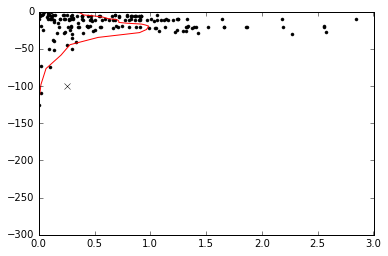

In [17]:
# create depth-weighted mean profile using gaussian filter
zs=np.array(TS.variables['deptht'])
plt.plot(qNH,-qP,'k.')
AmmProf=ginterp(qP,0.0,qNH,10,zs)
plt.plot(AmmProf,-zs,'r-')
plt.plot(remNH,-remP,'kx')

In [18]:
for ii in range(0,zs.size):
    voNH4[:,ii,0,:]=AmmProf[ii]

DON

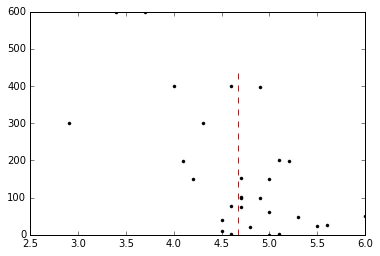

In [19]:
# take nearest available data to SJDF
q=session.query(Station.StartYear,Station.StartMonth,Press, Station.Lat, Station.Lon,Obs.Depth,
                Obs.Nitrogen_Dissolved_Organic,Obs.Nitrogen_Dissolved_Organic_units,Tem).\
        select_from(Obs).join(Station,Station.ID==Obs.StationTBLID).\
        filter(Obs.Nitrogen_Dissolved_Organic!=None).filter(Obs.Nitrogen_Dissolved_Organic>=0).\
        filter(Station.Lat!=None).filter(Station.Lon!=None).\
        filter(Station.Lat<48.8).filter(Station.Lon<-125).all()

qDON=[]
for row in q:
    qDON.append(row[6])
    plt.plot(row[6],row[2],'k.')
val_DON=np.mean(qDON)
plt.plot((val_DON,val_DON),(0,450),'r--')

In [20]:
voDON[:,:,:,:]=val_DON

PON

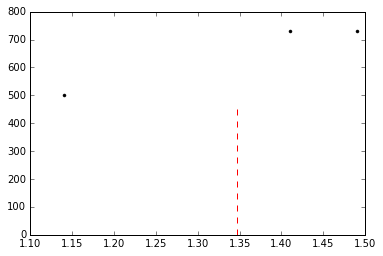

In [21]:
# take nearest available data to SJDF
q=session.query(Station.StartYear,Station.StartMonth,Press, Station.Lat, Station.Lon,Obs.Depth,
                Obs.Nitrogen_Particulate_Organic,Obs.Nitrogen_Particulate_Organic_units,Tem).\
        select_from(Obs).join(Station,Station.ID==Obs.StationTBLID).\
        filter(Obs.Nitrogen_Particulate_Organic!=None).filter(Obs.Nitrogen_Particulate_Organic>=0).\
        filter(Station.Lat!=None).filter(Station.Lon!=None).\
        filter(Station.Lat<48.8).filter(Station.Lon<-125).all()

qPON=[]
for row in q:
    qPON.append(row[6])
    plt.plot(row[6],row[2],'k.')
val_PON=np.mean(qPON)
plt.plot((val_PON,val_PON),(0,450),'r--')

In [22]:
voPON[:,:,:,:]=val_PON

NO3:

In [30]:
q=session.query(JDFLocs.ObsID, Station.StartYear,Station.StartMonth,Press,
                NO,NOUnits,Tem,SA, func.count()).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Station,Station.ID==Obs.StationTBLID).\
        join(Calcs,Calcs.ObsID==Obs.ID).filter(NO!=None).group_by(NOUnits).\
        all()
for row in q:
    print(row)

(80451, 1971.0, 6.0, None, 19.4, 'mmol/m**3', 7.1, None, 209)
(60308, 2000.0, 8.0, 208.4, 34.5, 'umol/L', 6.9444, 34.07842114607245, 2610)


In [ ]:
# umol/L=mmol/m**3, so all NO units the same
q=session.query(JDFLocs.ObsID, Station.StartYear,Station.StartMonth,Press,NO,Tem,SA).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Station,Station.ID==Obs.StationTBLID).\
        join(Calcs,Calcs.ObsID==Obs.ID).filter(SA<38).filter(SA>0).filter(NO!=None).\
        filter(Tem!=None).filter(SA!=None).filter(Press!=None).\
        all()
#for row in q:
#    print(row)

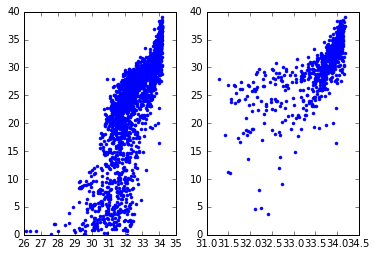

In [48]:
qYr=[]
qMn=[]
qP=[]
qNO=[]
qTC=[]
qSA=[]
qNO50=[]
qSA50=[]
qTC50=[]
for OID, Yr, Mn, P, NO3, T, S_A in q:
    qYr.append(Yr)
    qMn.append(Mn)
    qP.append(P)
    qNO.append(NO3)
    qTC.append(gsw.CT_from_t(S_A,T,P))
    qSA.append(S_A)
    if P>80:
        qNO50.append(NO3)
        qTC50.append(gsw.CT_from_t(S_A,T,P))
        qSA50.append(S_A)
fig,axs=plt.subplots(1,2)
qSA=np.array(qSA)
qTC=np.array(qTC)
qP=np.array(qP)
qNO=np.array(qNO)
qSA50=np.array(qSA50)
qTC50=np.array(qTC50)
qNO50=np.array(qNO50)
#plt.axis([28,35,0,40])
axs[0].plot(qSA,qNO,'.')
#axs[0].xlabel('Salinity')
#axs[0].ylabel('NO')
axs[1].plot(qSA50,qNO50,'.')
#axs[1].xlabel('Salinity')
#axs[1].ylabel('NO')

-4.42338724501 1.92716017533 -1.25030187987


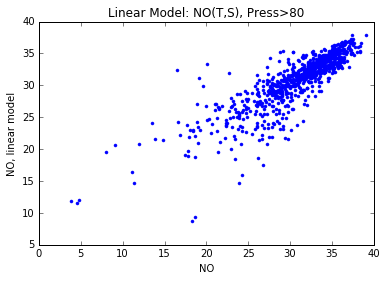

In [51]:
a=np.vstack([qTC50,qSA50,np.ones(len(qTC50))]).T
a2=np.vstack([qTC,qSA,np.ones(len(qTC))]).T
m = np.linalg.lstsq(a,qNO50)[0]
mT, mS, mC = m
print(mT, mS, mC)
plt.plot(qNO50,np.dot(a,m),'.')
plt.xlabel('NO')
plt.ylabel('NO, linear model')
SSE=np.dot((qNO50-np.dot(a,m)),(qNO50-np.dot(a,m)).T)
plt.title('Linear Model: NO(T,S), Press>80')


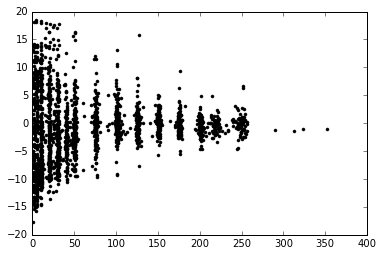

In [53]:
plt.plot(qP,np.dot(a2,m)-qNO,'k.')

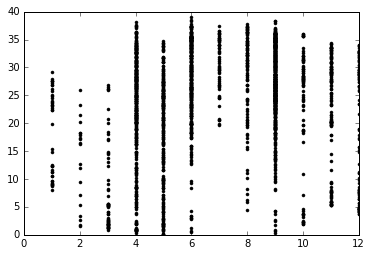

In [55]:
plt.plot(qMn,qNO,'k.')

In [56]:
zupper=np.extract(zs<100, zs)
print(zupper)

[  0.5000003    1.5000031    2.50001144   3.50003052   4.50007057
   5.50015068   6.50031042   7.50062323   8.50123596   9.50243282
  10.50476551  11.50931168  12.51816654  13.53541183  14.56898212
  15.63428783  16.76117325  18.00713539  19.48178482  21.38997841
  24.10025597  28.22991562  34.68575668  44.51772308  58.48433304
  76.58558655  98.06295776]


In [57]:
print(TS.variables['votemper'])

<class 'netCDF4._netCDF4.Variable'>
float32 votemper(time_counter, deptht, yb, xbT)
    units: degC
    long_name: Temperature
    coordinates: nav_lon nav_lat deptht time_counter
    grid: SalishSea
unlimited dimensions: time_counter
current shape = (52, 40, 1, 870)
filling on, default _FillValue of 9.969209968386869e+36 used



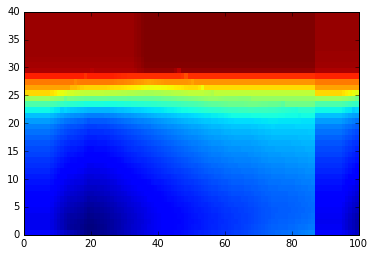

In [63]:

mesh0=plt.pcolormesh(mC +mT*TS.variables['votemper'][5,:,0,0:100]+mS*TS.variables['vosaline'][5,:,0,0:100])